In [1]:
import h5py
import operator
import os
from collections import defaultdict
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from scipy.stats import pearsonr, spearmanr

from genomic_utils.variant import Variant

In [2]:
ENFORMER_PREDS_DIR = "/data/yosef3/scratch/ruchir/data/enformer_hg19_predictions"
ISM_SCORES_DIR = "baseline.384_bins.new"

In [3]:
def load_enformer_sar_scores_for_chrom(
    chrom: str, variants: set[str], track_idx: int = 5110
) -> dict[str, float]:
    enformer_scores = {}
    h5_path = os.path.join(ENFORMER_PREDS_DIR, f"1000G.MAF_threshold=0.005.{chrom}.h5")

    with h5py.File(h5_path, "r") as f:
        chr_ = f["chr"][:].astype(str)
        pos = f["pos"][:].astype(int)
        ref = f["ref"][:].astype(str)
        alt = f["alt"][:].astype(str)
        sar = f["SAR"][:, track_idx]

        for i in range(len(chr_)):
            v_original = str(Variant(chr_[i], pos[i], ref[i], alt[i]))
            v_flipped = str(Variant(chr_[i], pos[i], alt[i], ref[i]))
            if v_original in variants:
                enformer_scores[v_original] = sar[i]
            elif v_flipped in variants:
                enformer_scores[v_flipped] = -1.0 * sar[i]

    return enformer_scores


def load_enformer_sar_scores(
    variants: set[str], track_idx: int = 5110
) -> dict[str, float]:
    enformer_scores = Parallel(n_jobs=22)(
        delayed(load_enformer_sar_scores_for_chrom)(str(chrom), variants, track_idx)
        for chrom in range(1, 23)
    )
    return reduce(operator.ior, enformer_scores)

In [4]:
def get_my_sar_scores() -> dict[str, float]:
    my_scores = defaultdict(list)

    for fname in tqdm(os.listdir(ISM_SCORES_DIR)):
        if fname.endswith(".csv"):
            df = pd.read_csv(os.path.join(ISM_SCORES_DIR, fname), index_col=0)
            # scale by 128 to match Enformer's calculation where they summed over all 128 bins
            df["SAR"] = np.log2(1 + df["variant"] * 128) - np.log2(1 + df["ref"] * 128)
            for v, sar in df["SAR"].items():
                my_scores[v].append(sar)

    return {v: np.mean(sars) for v, sars in my_scores.items()}

In [5]:
my_scores = get_my_sar_scores()

  0%|          | 0/500 [00:00<?, ?it/s]

In [7]:
enformer_scores = load_enformer_sar_scores(set(my_scores.keys()))

In [8]:
shared_variants = set(my_scores.keys()) & set(enformer_scores.keys())
print(f"Shared variants: {len(shared_variants)}/{len(my_scores)}")

my_scores_shared = np.array([my_scores[v] for v in shared_variants])
enformer_scores_shared = np.array([enformer_scores[v] for v in shared_variants])

Shared variants: 165573/218297


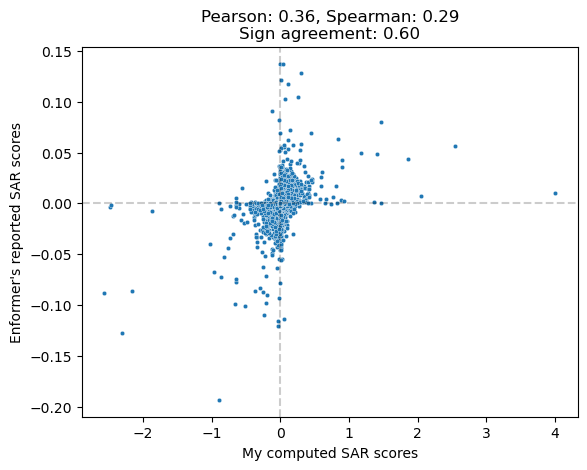

In [9]:
spearman, _ = spearmanr(my_scores_shared, enformer_scores_shared)
pearson, _ = pearsonr(my_scores_shared, enformer_scores_shared)
sign_agreement = np.mean(np.sign(my_scores_shared) == np.sign(enformer_scores_shared))

fig, ax = plt.subplots()
sns.scatterplot(x=my_scores_shared, y=enformer_scores_shared, s=10, ax=ax)
ax.axhline(0, color="black", linestyle="--", alpha=0.2)
ax.axvline(0, color="black", linestyle="--", alpha=0.2)
ax.set_xlabel("My computed SAR scores")
ax.set_ylabel("Enformer's reported SAR scores")
ax.set_title(
    f"Pearson: {pearson:.2f}, Spearman: {spearman:.2f}"
    + "\n"
    + f"Sign agreement: {sign_agreement:.2f}"
)
plt.show()